In [443]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import scipy.linalg as la
import pywt as pw

In [436]:
N = 1024
M = 512
K = 10
x,xs = RandomKSparseSignal(K,N)
F = RandomOrthoProjection(M,N)
y = np.dot(F,x)

def MSE(x,y):
    mseval = np.mean(np.power(x-y,2))    
    return mseval

def RandomOrthoProjection(M,N):
    return la.orth(np.random.randn(N,M)).T

def RandomKSparseSignal(K,N):
    """ Create a random realization of a K-sparse signal.
    """
    x = np.random.randn(N,1)
    s = np.zeros((N,1),dtype=bool)
    si = np.random.permutation(N)[1:K]
    s[si] = True
    x[np.invert(s)] = 0.0
    return x, s

def ShowRecovery(x,y):
    plt.rc('text',usetex=True)
    plt.rc('font', family='serif')
    
    f = plt.figure(figsize=(10,5),dpi=300)
    plt.plot(x,':ob');
    plt.plot(y,':xr');
    plt.axis("tight")
    plt.grid(True)
    plt.xlabel("Index", fontsize=16)
    plt.ylabel("Value", fontsize=16)
    
    mseval = MSE(x,y)
    
    
def ShowSignal(x):
    plt.rc('text',usetex=True)
    plt.rc('font', family='serif')
    
    f = plt.figure(figsize=(10,5),dpi=200)
    plt.plot(x);
    plt.axis("tight")
    plt.grid(True)
    plt.xlabel("Index", fontsize=16)
    plt.ylabel("Value", fontsize=16)

## Orthogonal Matching Pursuit (OMP)
---

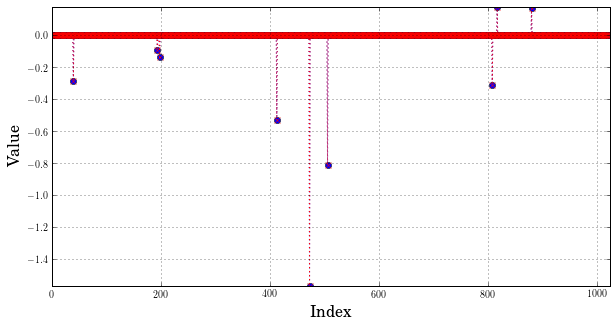

In [437]:
def OrthogonalMatchingPursuit(F,y,K):
    m,n = np.shape(F)
    Support = np.empty((0,1),dtype=int)
    r = y
    A = []
    
    # Main Loop
    for t in range(1,K):
        # Find max correlated column over
        # all posibilities
        response = np.abs(np.dot(F.T,r))
        maxcorrcol = response.argmax()
        Support = np.append(Support,maxcorrcol)
        Support = np.unique(Support)
        NS = np.size(Support)

        # Construct the subset matrix
        A = F[:,Support.astype(int)]
        A = np.reshape(A,(m,NS))
        # Solve the LSQ problem
        if NS>1:
            xs = la.lstsq(A,y)[0]
            a = np.dot(A,xs)
        else:
            xs = lm.LinearRegression().fit(A,y).coef_[0]
            a = xs*A
            
        # Update residual
        r = np.reshape(r,(m,1))
        a = np.reshape(a,(m,1))
        r = y-a
        
    x = np.zeros((n,1))
    x[Support] = xs
    BoolSupport = np.zeros((n,1),dtype=bool)
    BoolSupport[Support] = True
    return x, BoolSupport

myxomp,Support = OrthogonalMatchingPursuit(F,y,K)
# ShowSignal(x)
# ShowSignal(myxomp)
ShowRecovery(x,myxomp)

## Iterative Hard Thresholding (IHT)
---

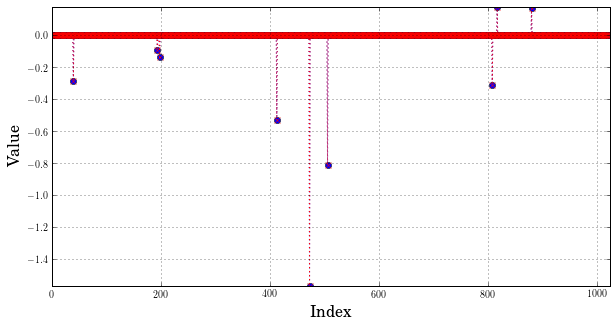

In [438]:
def TopKThreshold(x,K):
    S = np.argsort(abs(x),axis=0)[::-1][:K]
    xT = np.zeros_like(x)
    xT[S] = x[S]
    
    return xT, S

def IterativeHardThresholding(F,y,K,iters):
    m,n = np.shape(F)
    x = np.zeros((n,1))
    for i in range(1,iters):
        r = y - np.dot(F,x)
        z = x + np.dot(F.T,r)
        x = TopKThreshold(z,K)[0]

    return x

xiht = IterativeHardThresholding(F,y,K,100)

# ShowSignal(x)
# ShowSignal(xiht)
ShowRecovery(x,xiht)
        

## Compressive Sampling Matching Pursuit (CoSaMP)
---

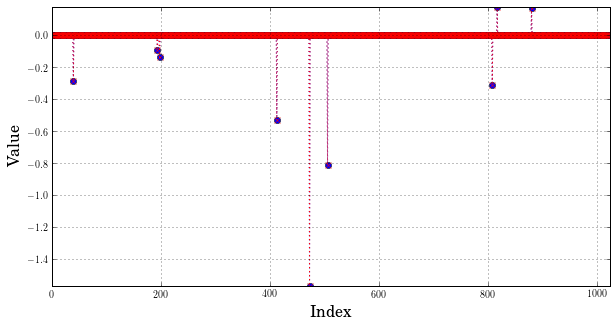

In [439]:
def CompSampMatchingPursuit(F,y,K, iters):
    m,n = np.shape(F)
    a = np.zeros((n,1))
    v = y
    S = np.empty((0,1),dtype=int)
    
    for k in range(1,iters):
        # Form Signal PRoxy
        x = np.dot(F.T,v)     
        
        # Identify large components
        O = TopKThreshold(x,2*K)[1]
        
        # Merge Supports
        T = np.append(O,S)
        T = np.unique(T)

        # Solve reduced system
        b = np.zeros((n,1))
        b[T] = la.lstsq(F[:,T],y)[0]
        
        # Prune approximation
        a,S = TopKThreshold(b,K)
        
        # Update residual
        v = y - np.dot(F,a)        
    
    return a

xcosamp = CompSampMatchingPursuit(F,y,K,10)

# ShowSignal(x)
# ShowSignal(xcosamp)
ShowRecovery(x,xcosamp)

## L1 Minimization (LASSO)
---

In [440]:
def L1Minimization(F,y,lam=1):
    return lm.Lasso(alpha=lam).fit(F,y).coef_

def ShowLassoPathMSE(F,y,x):
    NExp = 50
    Alphas = np.logspace(-8,0,NExp)
    out = lm.lasso_path(F,y,eps=0.01,alphas=Alphas)
#     Alphas = out[0]
    CoeffPath = out[1]
    
    MSEValues = np.zeros((NExp,1))
    for i in range(0,NExp):
        c = CoeffPath[:,:,i]
        MSEValues[i] = MSE(x,c)
    
    plt.plot(Alphas,MSEValues)
    plt.yscale("log")
    plt.xscale("log")

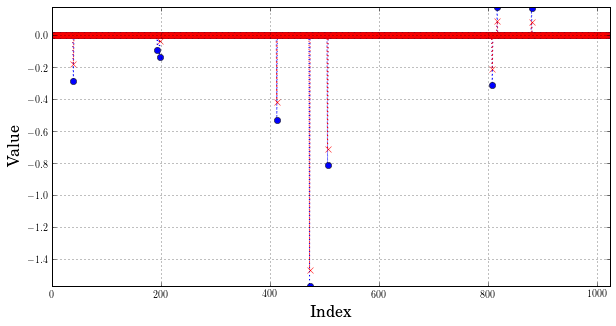

In [441]:
xl1 = L1Minimization(F,y,0.0001)

ShowRecovery(x,xl1)

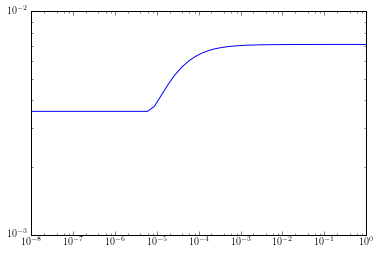

In [442]:
#     out = lm.lasso_path(F,y,eps=0.001,n_alphas=20)
#     print(np.shape(out[1]))
ShowLassoPathMSE(F,y,x)

## Iterative Soft Thresholding
---

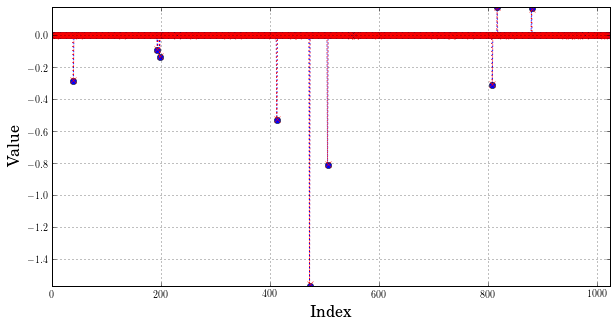

In [450]:
def IterativeSoftThresholding(F,y,lam,iters):
    m,n = np.shape(F)
    x = np.zeros((n,1))
    for i in range(1,iters):
        r = y - np.dot(F,x)
        z = x + np.dot(F.T,r)
        x = pw.threshold(z,lam,mode='soft')
    return x

xist = IterativeSoftThresholding(F,y,0.001,100)

ShowRecovery(x,xist)